# Assignment 11
Collaborative work by Adrian Bremer and Philipp Reinig

# Imports and Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random

/Users/philippreinig/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading the Dataset


In [2]:
(train_imgs, train_labels), (test_imgs, test_labels) = keras.datasets.cifar10.load_data()

### Preprocessing

In [3]:
# Casting the data-type to float32
train_imgs = train_imgs.astype('float32')
test_imgs = test_imgs.astype('float32')

train_labels = train_labels.astype('int32')
test_labels = train_labels.astype('int32')


# Normalizing all values to the range [0.0, 1.0]
train_imgs /= 255
test_imgs /= 255

### Checking the Dimensions of the Dataset

In [4]:
print(f"Training set: ")
print(f"\tDimensions of the images: {train_imgs.shape}")
print(f"\tDimensions of the labels: {train_labels.shape}")

print(f"Test set: ")
print(f"\tDimensions of the images: {test_imgs.shape}")
print(f"\tDimensions of the labels: {test_labels.shape}")

Training set: 
	Dimensions of the images: (50000, 32, 32, 3)
	Dimensions of the labels: (50000, 1)
Test set: 
	Dimensions of the images: (10000, 32, 32, 3)
	Dimensions of the labels: (50000, 1)


### Taking a look at some Example Images as Numpy Arrays

In [5]:
for i in range(3):
  rand_indx = random.randint(0, len(train_imgs) - 1)
  print(f"Image {rand_indx}:")
  print(f"{train_imgs[rand_indx]}")


Image 2095:
[[[0.07843138 0.03137255 0.01568628]
  [0.06666667 0.02352941 0.01568628]
  [0.07843138 0.01568628 0.01568628]
  ...
  [0.06666667 0.03137255 0.01960784]
  [0.05098039 0.01960784 0.01176471]
  [0.03921569 0.01568628 0.00784314]]

 [[0.09411765 0.03921569 0.01568628]
  [0.07058824 0.03137255 0.01568628]
  [0.09019608 0.01960784 0.01176471]
  ...
  [0.0627451  0.02745098 0.01176471]
  [0.05490196 0.02352941 0.01176471]
  [0.04705882 0.02352941 0.01176471]]

 [[0.07450981 0.03921569 0.01960784]
  [0.05882353 0.02745098 0.01568628]
  [0.10980392 0.03921569 0.02352941]
  ...
  [0.07843138 0.04313726 0.02352941]
  [0.0627451  0.02745098 0.01568628]
  [0.05098039 0.01960784 0.00784314]]

 ...

 [[0.4        0.27058825 0.15294118]
  [0.45490196 0.3254902  0.18039216]
  [0.5019608  0.36078432 0.20784314]
  ...
  [0.5019608  0.44705883 0.3882353 ]
  [0.43137255 0.36862746 0.3137255 ]
  [0.3254902  0.26666668 0.21960784]]

 [[0.41568628 0.2901961  0.15294118]
  [0.44705883 0.32156864 

### Taking a Look at some Example Images

Image 23403:


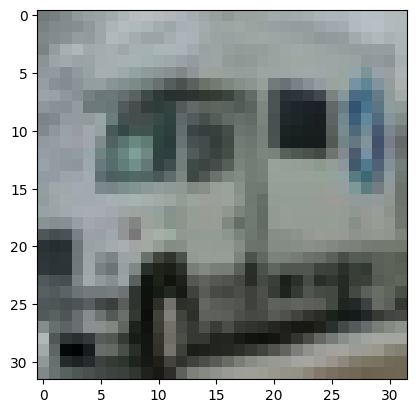

Image 26276:


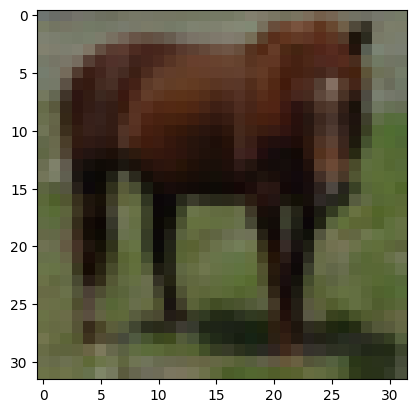

Image 11640:


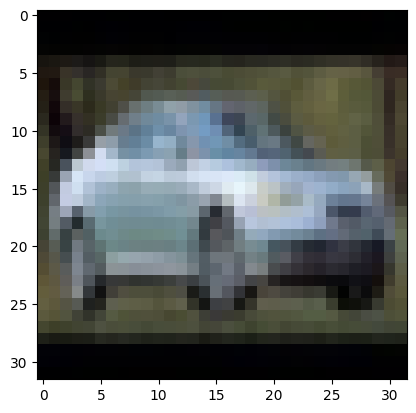

Image 43094:


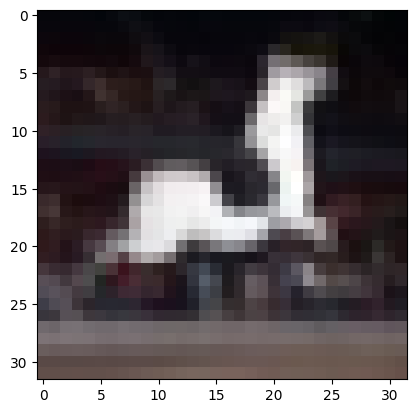

Image 32054:


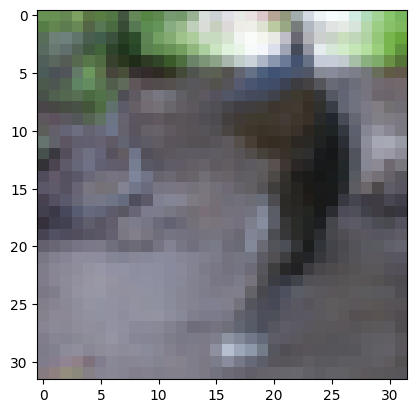

Image 9245:


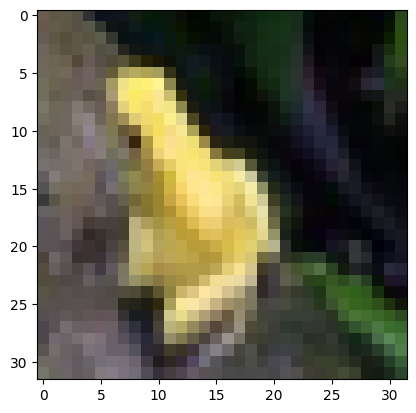

Image 26021:


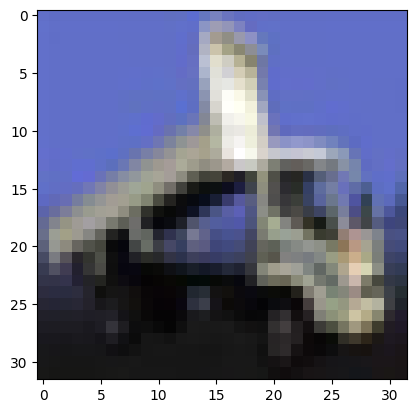

Image 21936:


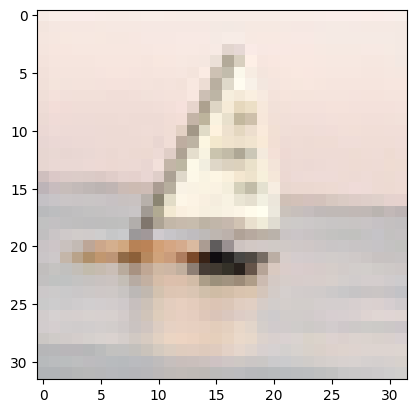

Image 3084:


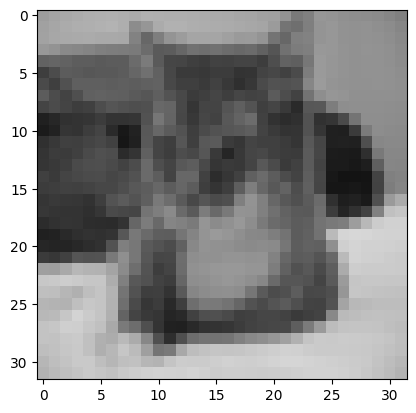

Image 24570:


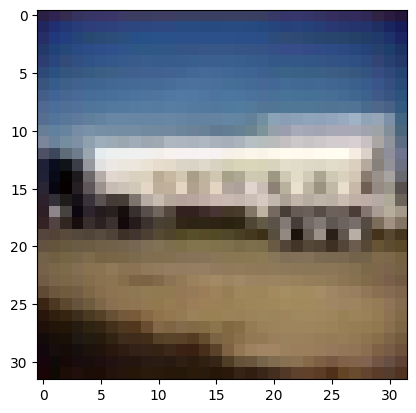

In [6]:
for i in range(10):
  rand_indx = random.randint(0, len(train_imgs) - 1)
  plt.imshow(train_imgs[rand_indx])
  print(f"Image {rand_indx}:")
  plt.show()

#  Implementing a Model for CIFAR-10

In [7]:
class ResBlock(keras.Model):
  count = 1

  def __init__(self, filters, kernel_size):
    super().__init__(name="ResBlock_"+str(ResBlock.count))
    self.filters=filters
    self.kernel_size=kernel_size

    self.conv1 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.bn1 = keras.layers.BatchNormalization()
    self.conv2 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.add = keras.layers.Add()
    self.relu = keras.layers.ReLU()
    self.bn2 = keras.layers.BatchNormalization()

    ResBlock.count += 1

  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible shape of x: ({inputs.shape}) and amount of filters: {self.filters}")

    x = tf.identity(inputs)
    x_initial = tf.identity(x)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)

    x = self.add([x_initial, x])
    x = self.relu(x)
    x = self.bn2(x)

    return x

class ResBlockGroup(keras.Model):

  count = 1

  def __init__(self, n: int, filters: int, kernel_size: int):
    super().__init__(name="ResBlockGroup_" + str(ResBlockGroup.count))

    if n < 1:
      raise ValueError("n has to be at least 1")

    self.n = n
    self.filters = filters
    self.kernel_size = kernel_size

    self.res_blocks = [ResBlock(self.filters, self.kernel_size) for _ in range(self.n)]

    ResBlockGroup.count += 1


  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible amount of filters and input shape")

    x = inputs

    for res_block in self.res_blocks:
      x = res_block(x)

    return x

  def get_functional_model(self):
    inputs = keras.Input(shape=(32,32,self.filters))

    return keras.Model(inputs=inputs, outputs=self.call(inputs))

class CiFar10ResNetModel(keras.Model):

  def __init__(self):
    super().__init__(name="CiFar10ResNetModel")

    self.res_block_group_1 = ResBlockGroup(3,3,3)
    self.res_block_group_2 = ResBlockGroup(3,6,3)
    self.resize_layer_1 = keras.layers.Conv2D(6,1, 2, padding="same")
    self.avg_pooling = keras.layers.AveragePooling2D(pool_size=2)
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(10, name="Dense")

  def build(self, input_shape):
    pass

  def call(self, input):

    x = self.res_block_group_1(input)
    x = self.resize_layer_1(x)
    x = self.res_block_group_2(x)
    x = self.avg_pooling(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x


  def get_functional_model(self) -> keras.Model:

    input = keras.Input(shape=(32,32,3))

    return keras.Model(inputs=input, outputs=self.call(input))



In [8]:
model = CiFar10ResNetModel().get_functional_model()

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

### Training

In [9]:
# Creating the datasets
batch_size = 100


train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels)).shuffle(50_000).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels)).shuffle(50_000).batch(batch_size).repeat()

train_data_size = float('inf') if train_data.cardinality() == tf.data.INFINITE_CARDINALITY else len(train_data)
test_data_size = float('inf') if test_data.cardinality() == tf.data.INFINITE_CARDINALITY else len(test_data)

# Checking the sizes
print(f"Training dataset contains {train_data_size} batches with {batch_size} elements each -> {train_data_size*batch_size} total elements")
print(f"Test dataset contains {test_data_size} batches with {batch_size} elements each -> {test_data_size*batch_size} total elements")

ValueError: Dimensions 10000 and 50000 are not compatible

In [ ]:
print(model.metrics_names)

[]


In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

class EvaluationCallback (tf.keras.callbacks.Callback):

  def __init__(self, train_data_size_, test_data_size_, batch_size_):
    super().__init__()
    self.train_data_size_ = train_data_size_
    self.test_data_size_ = test_data_size_
    self.batch_size_ = batch_size_


  def on_epoch_end(self, epoch, logs=None):
    print("")

    train_loss_, train_acc_ = self.model.evaluate(train_data, verbose=0, steps=self.train_data_size_)
    train_loss_ = round(train_loss_, 3)
    train_acc_ = round(train_acc_, 3)
    train_loss.append(train_loss_)
    train_acc.append(train_acc_)
    print(f"\tTrain loss: {train_loss_}, Train accuracy {train_acc_}")

    test_loss_, test_acc_ = self.model.evaluate(test_data, verbose=0, steps=self.test_data_size_)
    test_loss_ = round(test_loss_, 3)
    test_acc_ = round(test_acc_, 3)
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    print(f"\tTest loss: {test_loss_}, Test accuracy {test_acc_}")


In [ ]:
train_loss.clear()
train_acc.clear()
test_loss.clear()
test_acc.clear()

train_data_size_effective = train_imgs.shape[0]/batch_size if train_data_size == float('inf') else train_data_size
test_data_size_effective = test_imgs.shape[0]/batch_size if test_data_size == float('inf') else test_data_size

model.fit(train_data, epochs=30, steps_per_epoch=100, callbacks=[EvaluationCallback(train_data_size_effective, test_data_size_effective, batch_size)])

Epoch 1/30
 99/100 [============================>.] - ETA: 0s - loss: 2.1816 - accuracy: 0.2096
	Train loss: 2.439, Train accuracy 0.106
	Test loss: 2.437, Test accuracy 0.105
100/100 [==============================] - 14s 139ms/step - loss: 2.1790 - accuracy: 0.2105
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.8429 - accuracy: 0.3294
	Train loss: 2.471, Train accuracy 0.139
	Test loss: 2.466, Test accuracy 0.136
100/100 [==============================] - 14s 144ms/step - loss: 1.8429 - accuracy: 0.3294
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.6855 - accuracy: 0.3739
	Train loss: 2.193, Train accuracy 0.207
	Test loss: 2.196, Test accuracy 0.204
100/100 [==============================] - 14s 137ms/step - loss: 1.6855 - accuracy: 0.3739
Epoch 4/30
 99/100 [============================>.] - ETA: 0s - loss: 1.6068 - accuracy: 0.4148
	Train loss: 1.703, Train accuracy 0.374
	Test loss: 1.703, Test accuracy 0.37
100/100 [============

In [ ]:
model.save("my_model.keras")

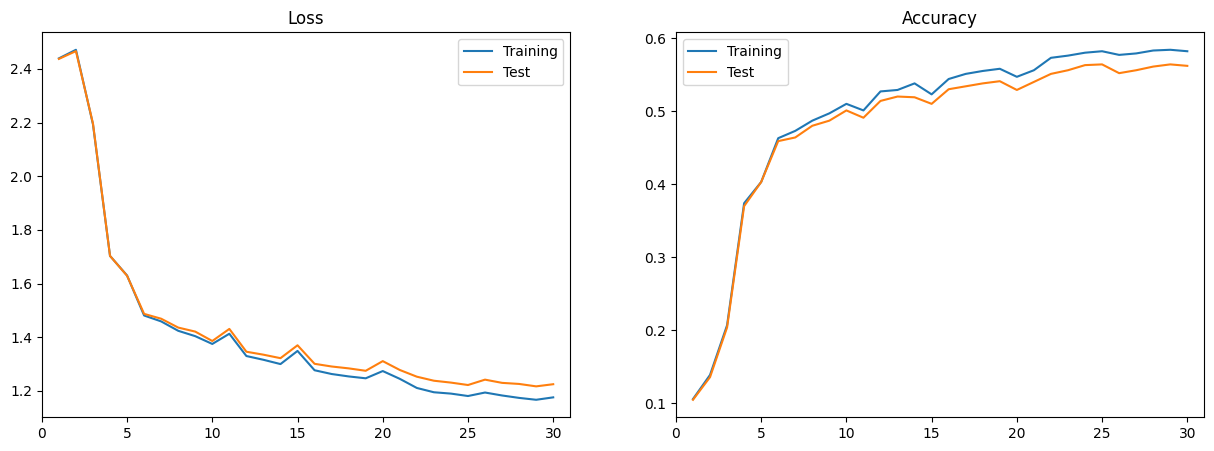

In [ ]:
def plot_training_curves(train_loss_, train_acc_, test_loss_, test_acc_):
  epochs = len(train_loss_)
  x_lbls = np.arange(1, epochs+1)

  # print(f"Training loss: {train_loss_}")
  # print(f"Training accuracy: {train_acc_}")

  # print(f"Test loss: {test_acc_}")
  # print(f"Test accuracy: {test_acc_}")


  fig, (ax_loss, ax_acc) = plt.subplots(1,2, figsize=(15,5))
  train_loss_curve, = ax_loss.plot(x_lbls, train_loss_, label='Training')
  test_loss_curve, = ax_loss.plot(x_lbls, test_loss_, label='Test')
  ax_loss.legend(handles=[train_loss_curve, test_loss_curve])

  ax_loss.set_title("Loss")
  ax_loss.set_xlim(0, x_lbls[len(x_lbls)-1] + 1)

  train_acc_curve, = ax_acc.plot(x_lbls, train_acc_, label='Training')
  test_acc_curve, = ax_acc.plot(x_lbls, test_acc_, label='Test')
  ax_acc.legend(handles=[train_acc_curve, test_acc_curve])

  ax_acc.set_title("Accuracy")
  ax_acc.set_xlim(0, x_lbls[len(x_lbls)-1] + 1)

  plt.show()

plot_training_curves(train_loss, train_acc, test_loss, test_acc)

### Creating Adversarial Examples

In [ ]:
inputs = tf.Variable(train_imgs[0:100])
lbls = tf.constant(train_labels[0:100].reshape(100,))

#print(inputs)
#print(lbls)

adv = tf.Variable(inputs)

const = 0.1


with tf.GradientTape() as adverserial_tape:
  adverserial_tape.watch(inputs)
  logits = model(inputs)

  xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbls))

grads = adverserial_tape.gradient(xent, inputs)

for i in range(inputs.shape[0]):
  val = tf.Variable(adv[i]).assign_add(grads[i] * const)
  val_clipped = tf.clip_by_value(val, 0, 1)
  #print(f"Value clipped: {val_clipped}")
  #print(f"Before update: {adv[i]}")
  adv = tf.tensor_scatter_nd_update(adv, [[i]], [val_clipped])
  #print(f"After update: {adv[i]}")


standard_loss, standard_acc = model.evaluate(inputs, lbls)
adv_loss, adv_acc = model.evaluate(adv, lbls)

print(f"Initial: Loss: {standard_loss}, Accuracy: {standard_acc}")
print(f"Adverserial Loss: {adv_loss}, Accuracy: {adv_acc}")









4/4 [==============================] - 0s 6ms/step - loss: 5.8686 - accuracy: 0.0000e+00
Initial: Loss: 5.137350559234619, Accuracy: 0.07000000029802322
Adverserial Loss: 5.868573188781738, Accuracy: 0.0
